<a href="https://colab.research.google.com/github/cferreira21/tp/blob/main/TP_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
%pip install swig
%pip install gymnasium[box2d]

In [132]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import itertools
import tqdm
import pandas as pd

In [134]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [135]:
NUM_EPISODES = 700
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.97
TARGET_UPDATE = 5
LEARNING_RATE = 5e-4
REPLAY_BUFFER_SIZE = 10000

In [136]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

        nn.init.orthogonal_(self.fc1.weight, gain=np.sqrt(2))
        nn.init.constant_(self.fc1.bias, 0.0)

        nn.init.orthogonal_(self.fc2.weight, gain=np.sqrt(2))
        nn.init.constant_(self.fc2.bias, 0.0)

        nn.init.orthogonal_(self.fc3.weight, gain=0.01)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def to(self, device):
        super().to(device)
        return self


In [137]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [138]:
class DQNAgent:
    def __init__(self, action_space, observation_space, lr, replay_buffer):
        self.action_space = action_space
        self.policy = DQN(observation_space, action_space).to(device)
        self.target = DQN(observation_space, action_space).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr)
        self.memory = ReplayBuffer(replay_buffer)
        self.steps_done = 0

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return torch.tensor([[np.random.randint(self.action_space)]], dtype=torch.long, device=device)
        else:
            state = torch.as_tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                q_values = self.policy(state)
                return q_values.max(1)[1].view(1, 1)

    def optimize_model(self, batch_size, gamma):
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.cat(batch[0]).to(device)
        action_batch = torch.cat(batch[1]).to(device)
        reward_batch = torch.cat(batch[2]).squeeze().to(device)
        next_state_batch = torch.cat(batch[3]).to(device)

        current_q_values = self.policy(state_batch).gather(1, action_batch)
        next_q_values = self.target(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (gamma * next_q_values)
        loss = F.mse_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target(self):
        self.target.load_state_dict(self.policy.state_dict())



In [139]:
def train(num_episodes=NUM_EPISODES,
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        target_update=TARGET_UPDATE,
        learning_rate=LEARNING_RATE,
        replay_buffer_size=REPLAY_BUFFER_SIZE
        ):

    env = gym.make('LunarLander-v3')
    agent = DQNAgent(env.action_space.n, env.observation_space.shape[0], learning_rate, replay_buffer_size)

    episode_durations = []
    episode_rewards = []
    epsilon_hist = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0
        for t in range(1000):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, trunc, info = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward], dtype=torch.float32, device=device)
            done = done or trunc

            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memory.push((state, action, reward, next_state))
            state = next_state
            agent.optimize_model(batch_size, gamma)

            if done:
                episode_durations.append(t + 1)
                episode_rewards.append(total_reward)
                break
            epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
            epsilon_hist.append(epsilon)
        if episode % target_update == 0:
            agent.update_target()
        if episode % 25 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, AVG Reward(last 25 eps): {np.mean(episode_rewards[-25:]):.2f} Epsilon: {epsilon:.2f}")

    env.close()
    return agent, episode_rewards, episode_durations


# Teste de Hiperparâmetros:

In [140]:
def plot_rewards(rewards):
    if len(rewards) < 25:
        print("For plotting, rewards list must contain at least 25 elements")
        return
    smooth_rewards = np.convolve(rewards, np.ones(25)/25, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, alpha=0.3, label='Raw')
    plt.plot(range(24, len(rewards)), smooth_rewards, label='25-ep Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Performance')
    plt.legend()
    plt.show()

In [149]:
def train_evaluate(cfg):
    lr,epsidecay,epsistart,epsiend,tgt,batch,buf,episodes,gam = cfg
    agent, rewards, duration = train(
        num_episodes=episodes,
        batch_size=batch,
        gamma=gam,
        epsilon_start=epsistart,
        epsilon_end=epsiend,
        epsilon_decay=epsidecay,
        target_update=tgt,
        learning_rate=lr,
        replay_buffer_size=buf
    )

    plot_rewards(rewards)
    plt.figure(figsize=(10, 5))
    plt.plot(duration)

    return np.mean(rewards[-100:])


Testing replay buffer sizes:

In [147]:
search_grid = {
    'learning_rate':[5e-4],
    'epsilon_decay':[0.992],
    'epsilon_start':[1.0],
    'epsilon_end':[0.01],
    'target_update':[7],
    'batch_size':[32],
    'replay_buffer_size':[10000,20000],
    'num_episodes':[500],
    'gamma' : [0.99]
}

keys=list(search_grid.keys())
grid_combinations=list(itertools.product(*search_grid.values()))
results=[]
best_score=-1e9
best_config=None


In [ ]:
for cfg in tqdm.tqdm(grid_combinations, desc="Grid search", unit="Run"):
    score=train_evaluate(cfg)
    results.append((cfg,score))
    if score>best_score:
        best_score=score
        best_config=cfg

Grid search:   0%|          | 0/2 [00:00<?, ?Run/s]

Episode 0, Total Reward: -205.62, AVG Reward(last 25 eps): -205.62 Epsilon: 1.00
Episode 25, Total Reward: -175.94, AVG Reward(last 25 eps): -184.44 Epsilon: 0.82
Episode 50, Total Reward: -246.60, AVG Reward(last 25 eps): -173.27 Epsilon: 0.67
Episode 75, Total Reward: -5.20, AVG Reward(last 25 eps): -122.95 Epsilon: 0.55
Episode 100, Total Reward: -134.94, AVG Reward(last 25 eps): -107.07 Epsilon: 0.45
Episode 125, Total Reward: -644.53, AVG Reward(last 25 eps): -132.66 Epsilon: 0.37
Episode 150, Total Reward: -0.74, AVG Reward(last 25 eps): -113.59 Epsilon: 0.30
Episode 175, Total Reward: -92.51, AVG Reward(last 25 eps): -83.86 Epsilon: 0.25


In [143]:

df=pd.DataFrame([
 {'learning_rate':c[0],
  'epsilon_decay':c[1],
  'epsilon_start':c[2],
  'epsilon_end':c[3],
  'target_update':c[4],
  'batch_size':c[5],
  'replay_buffer_size':c[6],
  'num_episodes':c[7],
  'gamma':c[8],
  'score':s}
 for c,s in results])

display(df.head())

""


In [144]:
print("Best score:", best_score)
print("Best config:", best_config)

Best score: -1000000000.0
Best config: None


Episode 0, Total Reward: -145.13, AVG Reward(last 25 eps): -145.13 Epsilon: 1.00
Episode 25, Total Reward: -376.65, AVG Reward(last 25 eps): -176.32 Epsilon: 0.82
Episode 50, Total Reward: -61.43, AVG Reward(last 25 eps): -106.87 Epsilon: 0.67
Episode 75, Total Reward: -118.73, AVG Reward(last 25 eps): -128.12 Epsilon: 0.55
Episode 100, Total Reward: 39.13, AVG Reward(last 25 eps): -93.80 Epsilon: 0.45
Episode 125, Total Reward: 7.30, AVG Reward(last 25 eps): -207.74 Epsilon: 0.37
Episode 150, Total Reward: -335.25, AVG Reward(last 25 eps): -193.13 Epsilon: 0.30
Episode 175, Total Reward: -9.36, AVG Reward(last 25 eps): -86.93 Epsilon: 0.25
Episode 200, Total Reward: 29.64, AVG Reward(last 25 eps): -28.01 Epsilon: 0.20
Episode 225, Total Reward: -29.03, AVG Reward(last 25 eps): -24.39 Epsilon: 0.16
Episode 250, Total Reward: 6.08, AVG Reward(last 25 eps): -50.99 Epsilon: 0.13
Episode 275, Total Reward: -104.69, AVG Reward(last 25 eps): 11.01 Epsilon: 0.11


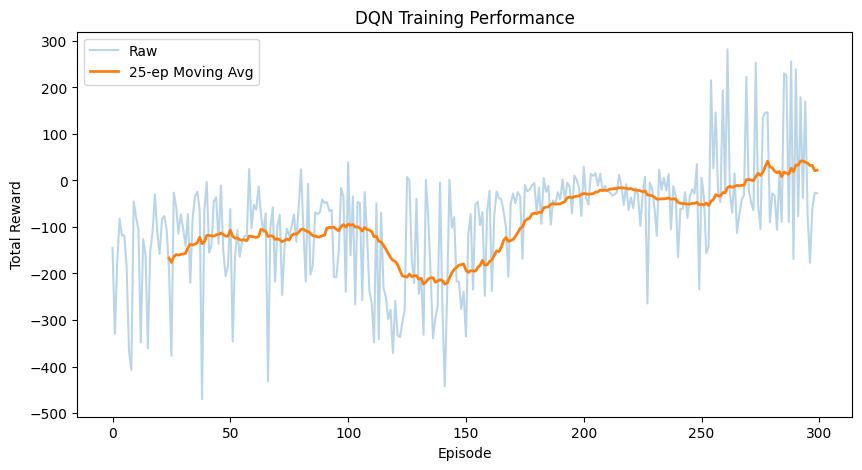

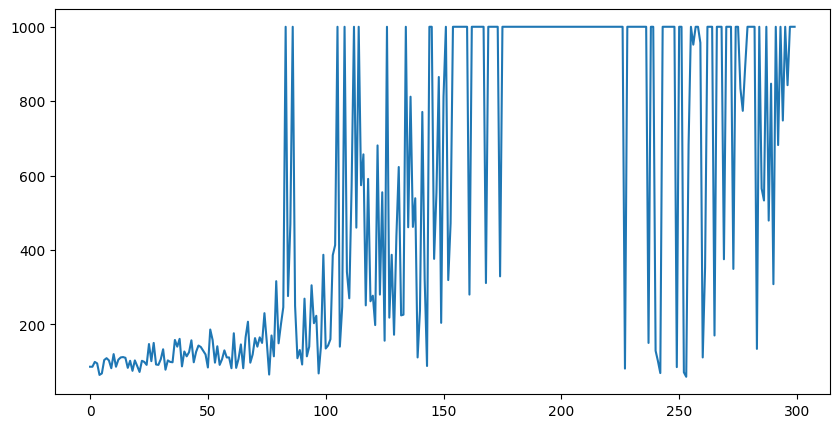

In [ ]:
agent, rewards, durations  = train(300)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

Episode 0, Total Reward: -129.19, AVG Reward(last 25 eps): -129.19 Epsilon: 1.00
Episode 25, Total Reward: -60.24, AVG Reward(last 25 eps): -165.11 Epsilon: 0.82
Episode 50, Total Reward: -286.14, AVG Reward(last 25 eps): -154.99 Epsilon: 0.67
Episode 75, Total Reward: -122.51, AVG Reward(last 25 eps): -78.76 Epsilon: 0.55
Episode 100, Total Reward: -308.98, AVG Reward(last 25 eps): -82.33 Epsilon: 0.45
Episode 125, Total Reward: -300.19, AVG Reward(last 25 eps): -124.67 Epsilon: 0.37
Episode 150, Total Reward: -271.21, AVG Reward(last 25 eps): -184.04 Epsilon: 0.30
Episode 175, Total Reward: -2.73, AVG Reward(last 25 eps): -59.21 Epsilon: 0.25
Episode 200, Total Reward: -59.30, AVG Reward(last 25 eps): -44.78 Epsilon: 0.20
Episode 225, Total Reward: -15.02, AVG Reward(last 25 eps): 0.60 Epsilon: 0.16
Episode 250, Total Reward: -204.88, AVG Reward(last 25 eps): -14.85 Epsilon: 0.13
Episode 275, Total Reward: -132.07, AVG Reward(last 25 eps): -41.75 Epsilon: 0.11
Episode 300, Total Rewa

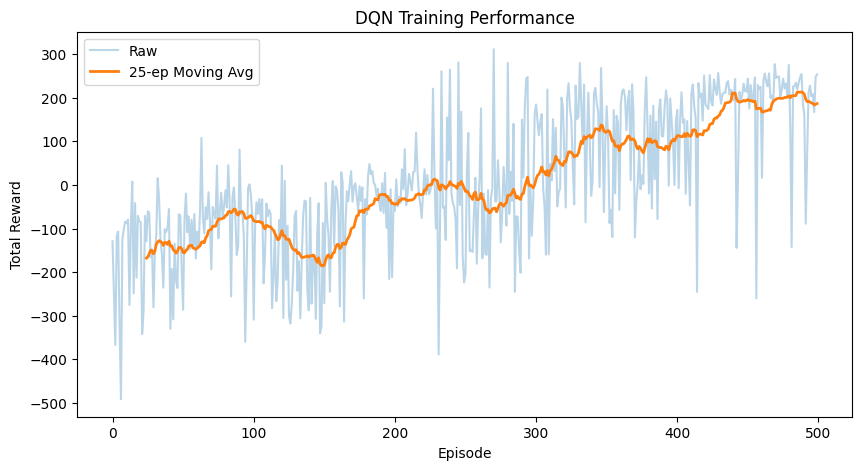

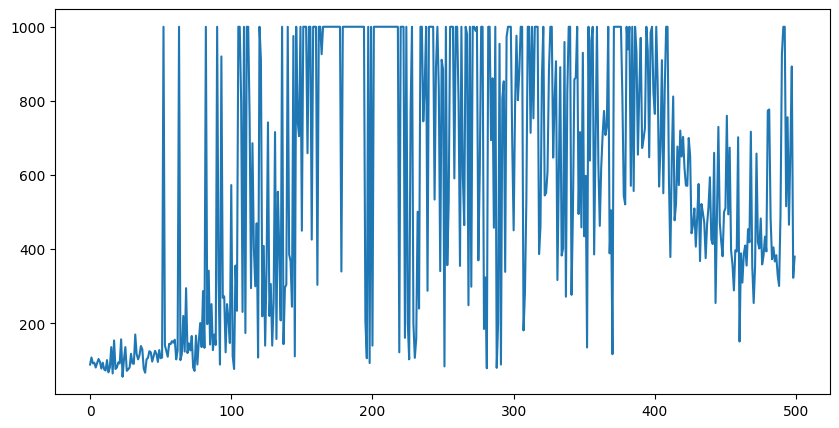

In [ ]:
agent, rewards, durations  = train(500)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

Episode 0, Total Reward: -73.34, AVG Reward(last 25 eps): -73.34 Epsilon: 1.00
Episode 25, Total Reward: -493.65, AVG Reward(last 25 eps): -206.54 Epsilon: 0.82
Episode 50, Total Reward: -93.16, AVG Reward(last 25 eps): -152.47 Epsilon: 0.67
Episode 75, Total Reward: -26.94, AVG Reward(last 25 eps): -119.40 Epsilon: 0.55
Episode 100, Total Reward: -209.85, AVG Reward(last 25 eps): -163.33 Epsilon: 0.45
Episode 125, Total Reward: -314.40, AVG Reward(last 25 eps): -191.64 Epsilon: 0.37
Episode 150, Total Reward: -294.98, AVG Reward(last 25 eps): -177.15 Epsilon: 0.30
Episode 175, Total Reward: -91.91, AVG Reward(last 25 eps): -172.01 Epsilon: 0.25
Episode 200, Total Reward: -24.44, AVG Reward(last 25 eps): -41.44 Epsilon: 0.20
Episode 225, Total Reward: -77.48, AVG Reward(last 25 eps): -26.75 Epsilon: 0.16
Episode 250, Total Reward: -16.70, AVG Reward(last 25 eps): -31.79 Epsilon: 0.13
Episode 275, Total Reward: 11.54, AVG Reward(last 25 eps): -5.31 Epsilon: 0.11
Episode 300, Total Rewar

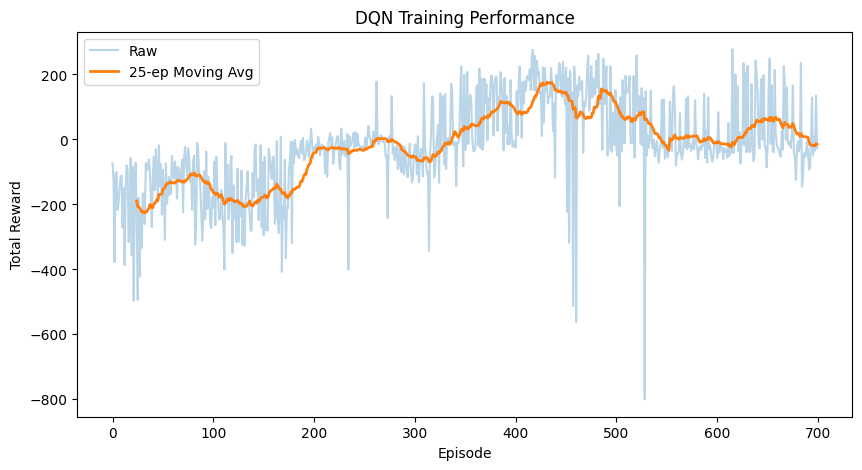

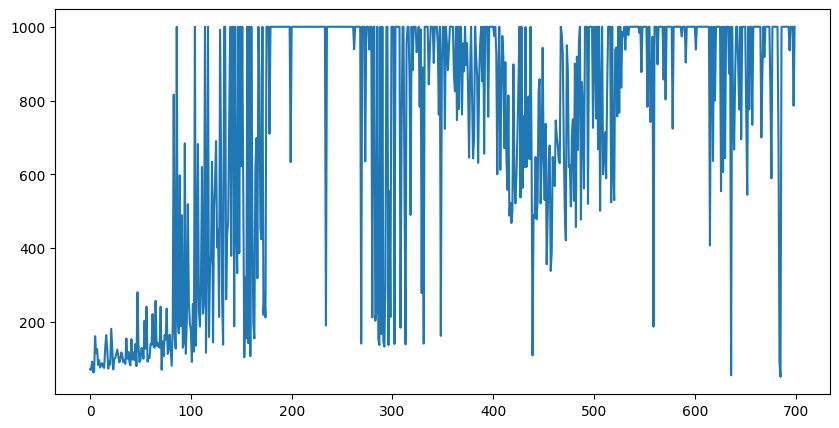

In [ ]:
agent, rewards, durations  = train(700)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

# Old tests:

In [ ]:
# agent3, rewards3, durations3 = train(5,64,0.99,1.0,0.01,0.995,10)
# plot_rewards(rewards3)

Episode 0, Total Reward: -216.10, AVG Reward(last 25 eps): -216.10 Epsilon: 1.00
Episode 25, Total Reward: -143.36, AVG Reward(last 25 eps): -180.12 Epsilon: 0.88
Episode 50, Total Reward: -49.95, AVG Reward(last 25 eps): -124.77 Epsilon: 0.78
Episode 75, Total Reward: -32.66, AVG Reward(last 25 eps): -139.70 Epsilon: 0.69
Episode 100, Total Reward: -110.43, AVG Reward(last 25 eps): -116.99 Epsilon: 0.61
Episode 125, Total Reward: -41.54, AVG Reward(last 25 eps): -113.80 Epsilon: 0.53
Episode 150, Total Reward: 31.75, AVG Reward(last 25 eps): -87.76 Epsilon: 0.47
Episode 175, Total Reward: -32.65, AVG Reward(last 25 eps): -69.99 Epsilon: 0.42
Episode 200, Total Reward: -47.88, AVG Reward(last 25 eps): -98.25 Epsilon: 0.37
Episode 225, Total Reward: -23.24, AVG Reward(last 25 eps): -108.83 Epsilon: 0.32
Episode 250, Total Reward: -4.60, AVG Reward(last 25 eps): -72.23 Epsilon: 0.29
Episode 275, Total Reward: -30.32, AVG Reward(last 25 eps): -62.86 Epsilon: 0.25
Episode 300, Total Reward

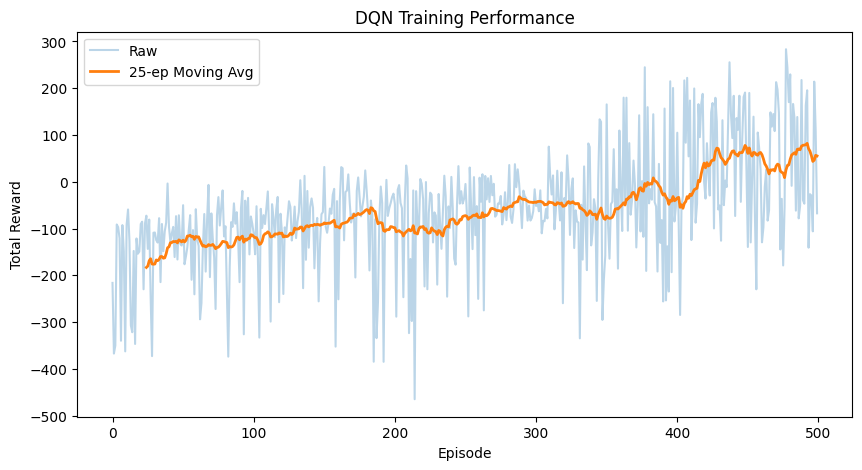

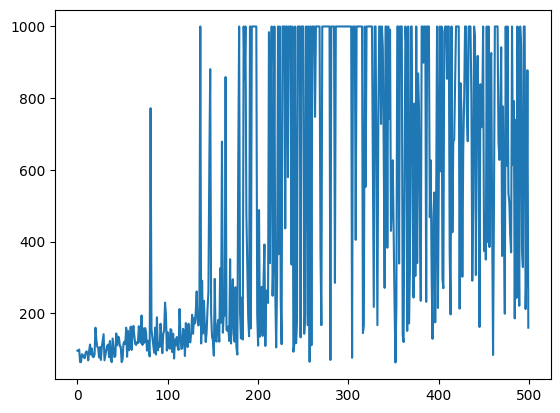

In [ ]:
# agent4, rewards4, durations4 = train(500,64,0.99,1.0,0.01,0.995,15)
# plot_rewards(rewards4)
# plt.plot(durations4)


Episode 0, Total Reward: -148.79, AVG Reward(last 25 eps): -148.79 Epsilon: 1.00
Episode 25, Total Reward: -130.00, AVG Reward(last 25 eps): -187.29 Epsilon: 0.88
Episode 50, Total Reward: -141.76, AVG Reward(last 25 eps): -145.77 Epsilon: 0.78
Episode 75, Total Reward: -267.95, AVG Reward(last 25 eps): -133.65 Epsilon: 0.69
Episode 100, Total Reward: -360.12, AVG Reward(last 25 eps): -110.49 Epsilon: 0.61
Episode 125, Total Reward: -90.16, AVG Reward(last 25 eps): -82.92 Epsilon: 0.53
Episode 150, Total Reward: -46.47, AVG Reward(last 25 eps): -102.13 Epsilon: 0.47
Episode 175, Total Reward: -204.20, AVG Reward(last 25 eps): -98.76 Epsilon: 0.42
Episode 200, Total Reward: -40.31, AVG Reward(last 25 eps): -120.09 Epsilon: 0.37
Episode 225, Total Reward: -69.96, AVG Reward(last 25 eps): -151.82 Epsilon: 0.32
Episode 250, Total Reward: -23.52, AVG Reward(last 25 eps): -72.50 Epsilon: 0.29
Episode 275, Total Reward: -139.08, AVG Reward(last 25 eps): -92.79 Epsilon: 0.25
Episode 300, Total

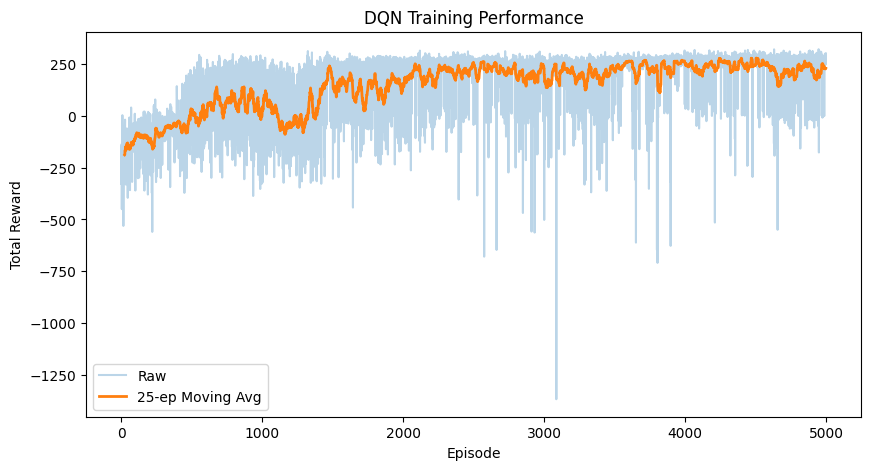

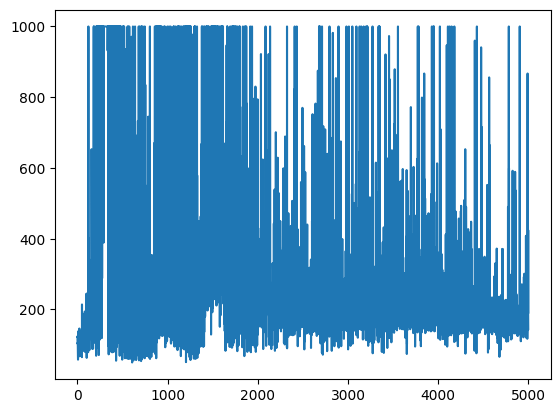

In [ ]:
# agent5, rewards5, durations5 = train(5000,64,0.99,1.0,0.01,0.995,20)
# plot_rewards(rewards5)
# plt.plot(durations5)

### Testing learning rate 5e-3:

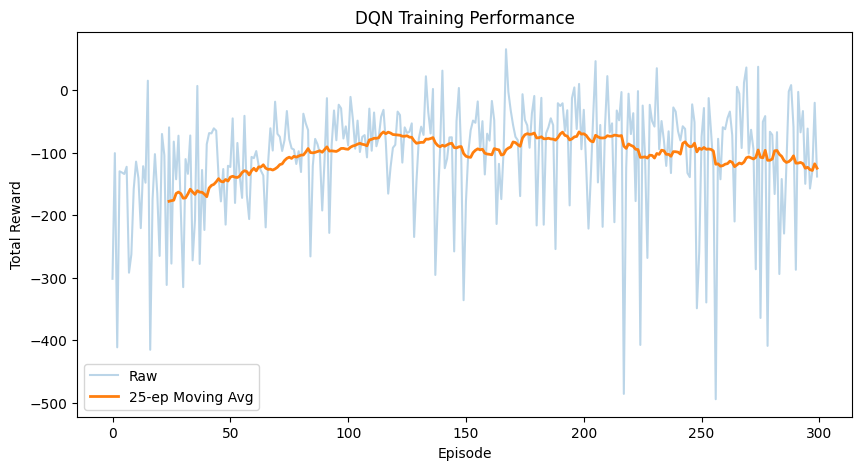

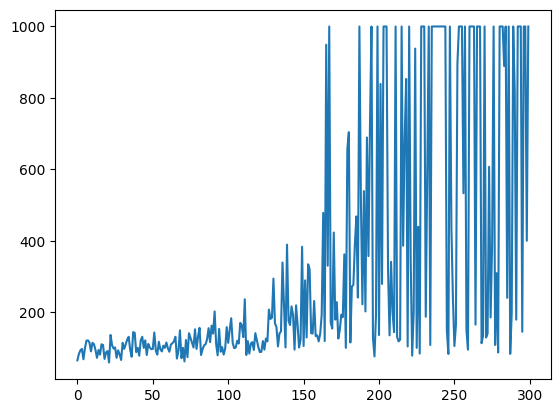

In [ ]:
agent7, rewards7, durations7 = train(300,64,0.99,1.0,0.01,0.995,15, 5e-3)
plot_rewards(rewards7)
plt.plot(durations7)

### Testing Learning rate 5e-5:

Episode 0, Total Reward: -149.11, AVG Reward(last 25 eps): -149.11 Epsilon: 1.00
Episode 25, Total Reward: -175.24, AVG Reward(last 25 eps): -171.63 Epsilon: 0.88
Episode 50, Total Reward: -175.08, AVG Reward(last 25 eps): -154.44 Epsilon: 0.78
Episode 75, Total Reward: -83.18, AVG Reward(last 25 eps): -166.72 Epsilon: 0.69
Episode 100, Total Reward: -87.15, AVG Reward(last 25 eps): -159.57 Epsilon: 0.61
Episode 125, Total Reward: -252.56, AVG Reward(last 25 eps): -175.50 Epsilon: 0.53
Episode 150, Total Reward: -62.24, AVG Reward(last 25 eps): -141.55 Epsilon: 0.47
Episode 175, Total Reward: -145.91, AVG Reward(last 25 eps): -135.39 Epsilon: 0.42
Episode 200, Total Reward: -82.29, AVG Reward(last 25 eps): -138.99 Epsilon: 0.37
Episode 225, Total Reward: -89.33, AVG Reward(last 25 eps): -162.07 Epsilon: 0.32
Episode 250, Total Reward: -6.88, AVG Reward(last 25 eps): -123.57 Epsilon: 0.29
Episode 275, Total Reward: -44.35, AVG Reward(last 25 eps): -125.82 Epsilon: 0.25
Episode 300, Tota

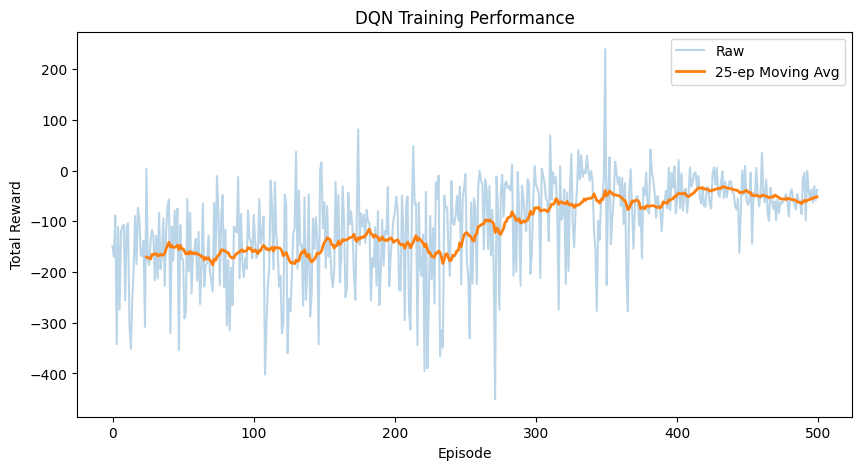

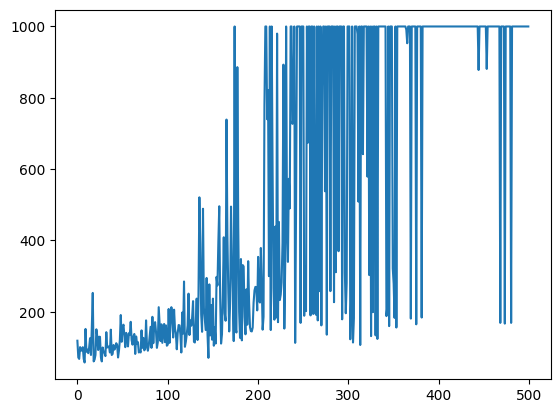

In [ ]:
agent8, rewards8, durations8 = train(500,64,0.99,1.0,0.01,0.995,15, 5e-5)
plot_rewards(rewards8)
plt.plot(durations8)

Episode 0, Total Reward: -298.45, AVG Reward(last 25 eps): -298.45 Epsilon: 1.00
Episode 25, Total Reward: -299.03, AVG Reward(last 25 eps): -206.93 Epsilon: 0.88
Episode 50, Total Reward: -28.43, AVG Reward(last 25 eps): -120.01 Epsilon: 0.78
Episode 75, Total Reward: -150.40, AVG Reward(last 25 eps): -104.86 Epsilon: 0.69
Episode 100, Total Reward: -112.44, AVG Reward(last 25 eps): -111.08 Epsilon: 0.61
Episode 125, Total Reward: -61.53, AVG Reward(last 25 eps): -76.01 Epsilon: 0.53
Episode 150, Total Reward: 6.43, AVG Reward(last 25 eps): -61.91 Epsilon: 0.47
Episode 175, Total Reward: 8.66, AVG Reward(last 25 eps): -81.96 Epsilon: 0.42
Episode 200, Total Reward: -29.79, AVG Reward(last 25 eps): -70.48 Epsilon: 0.37
Episode 225, Total Reward: -36.28, AVG Reward(last 25 eps): -46.30 Epsilon: 0.32
Episode 250, Total Reward: -30.31, AVG Reward(last 25 eps): -34.10 Epsilon: 0.29
Episode 275, Total Reward: 0.76, AVG Reward(last 25 eps): -10.09 Epsilon: 0.25
Episode 300, Total Reward: -34

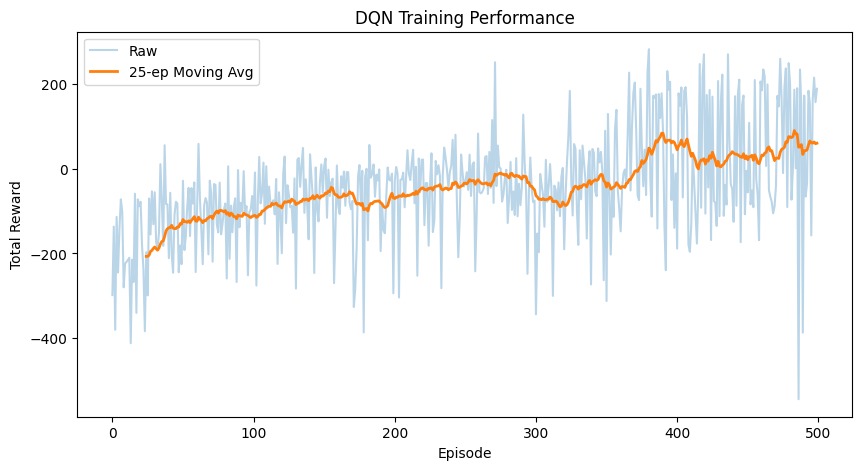

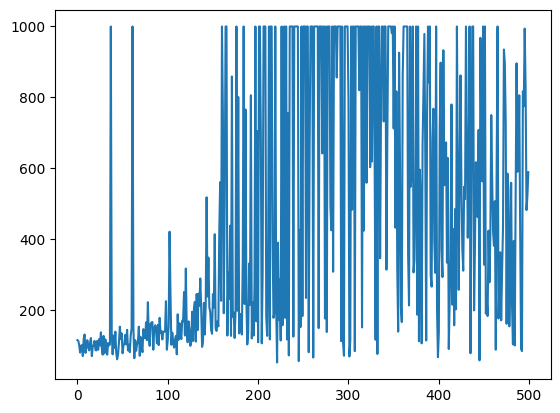

In [ ]:
agent9, rewards9, durations9 = train(500,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards9)
plt.plot(durations9)

### Test with 1000 episodes:

Episode 0, Total Reward: -303.97, AVG Reward(last 25 eps): -303.97 Epsilon: 1.00
Episode 25, Total Reward: -186.03, AVG Reward(last 25 eps): -184.83 Epsilon: 0.88
Episode 50, Total Reward: -276.28, AVG Reward(last 25 eps): -161.17 Epsilon: 0.78
Episode 75, Total Reward: -68.90, AVG Reward(last 25 eps): -138.82 Epsilon: 0.69
Episode 100, Total Reward: -82.62, AVG Reward(last 25 eps): -120.80 Epsilon: 0.61
Episode 125, Total Reward: -52.41, AVG Reward(last 25 eps): -104.95 Epsilon: 0.53
Episode 150, Total Reward: -240.45, AVG Reward(last 25 eps): -88.51 Epsilon: 0.47
Episode 175, Total Reward: -125.21, AVG Reward(last 25 eps): -62.68 Epsilon: 0.42
Episode 200, Total Reward: -121.08, AVG Reward(last 25 eps): -64.49 Epsilon: 0.37
Episode 225, Total Reward: -1.96, AVG Reward(last 25 eps): -88.60 Epsilon: 0.32
Episode 250, Total Reward: -299.94, AVG Reward(last 25 eps): -49.22 Epsilon: 0.29
Episode 275, Total Reward: -102.32, AVG Reward(last 25 eps): -75.99 Epsilon: 0.25
Episode 300, Total R

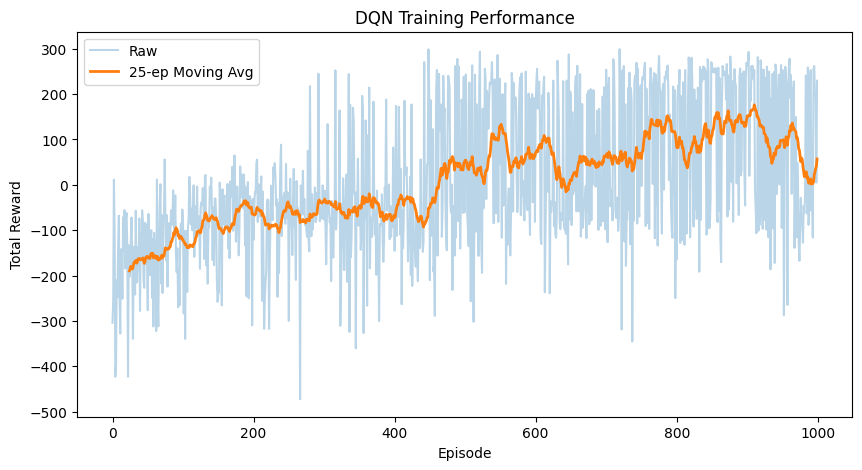

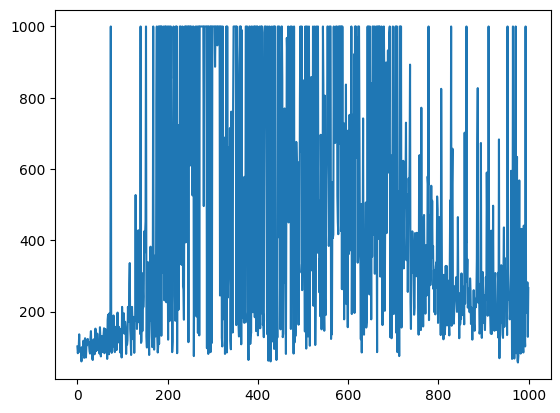

In [ ]:
agent10, rewards10, durations10 = train(1000,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards10)
plt.plot(durations10)

Episode 0, Total Reward: -39.97, AVG Reward(last 25 eps): -39.97 Epsilon: 1.00
Episode 25, Total Reward: -105.30, AVG Reward(last 25 eps): -206.51 Epsilon: 0.88
Episode 50, Total Reward: -219.62, AVG Reward(last 25 eps): -145.44 Epsilon: 0.78
Episode 75, Total Reward: -19.11, AVG Reward(last 25 eps): -145.83 Epsilon: 0.69
Episode 100, Total Reward: -29.31, AVG Reward(last 25 eps): -112.34 Epsilon: 0.61
Episode 125, Total Reward: 18.03, AVG Reward(last 25 eps): -110.86 Epsilon: 0.53
Episode 150, Total Reward: -62.19, AVG Reward(last 25 eps): -80.75 Epsilon: 0.47
Episode 175, Total Reward: -36.10, AVG Reward(last 25 eps): -106.43 Epsilon: 0.42
Episode 200, Total Reward: -204.43, AVG Reward(last 25 eps): -136.67 Epsilon: 0.37
Episode 225, Total Reward: -99.57, AVG Reward(last 25 eps): -150.82 Epsilon: 0.32
Episode 250, Total Reward: -33.70, AVG Reward(last 25 eps): -74.67 Epsilon: 0.29
Episode 275, Total Reward: -7.87, AVG Reward(last 25 eps): -60.56 Epsilon: 0.25
Episode 300, Total Rewar

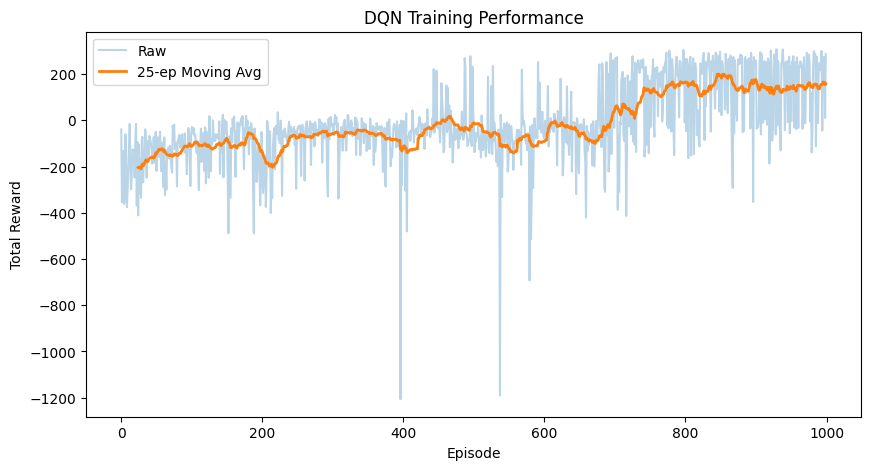

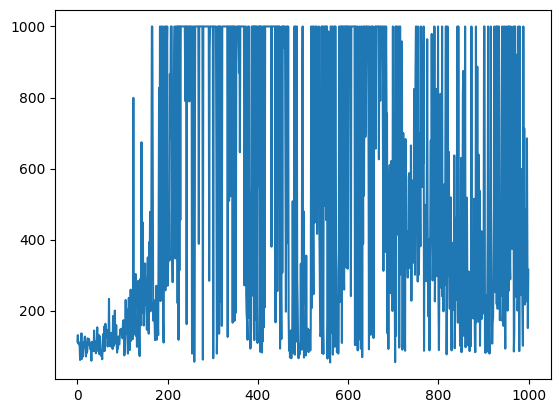

In [ ]:
agent, rewards, durations = train(1000,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards)
plt.plot(durations)

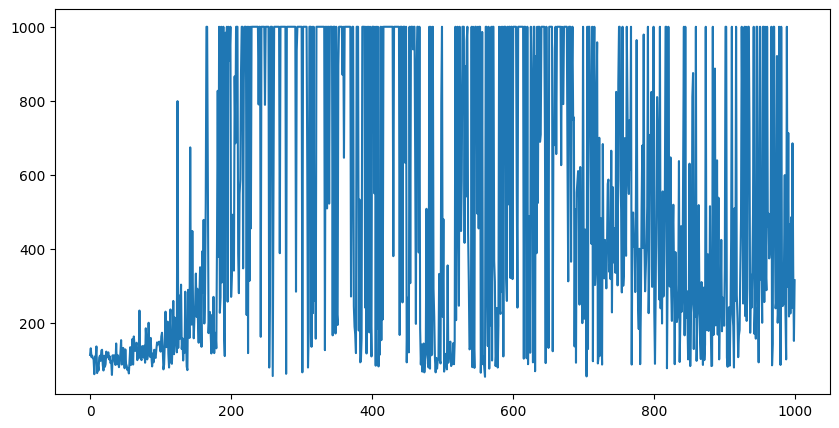

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(durations)

### testing faster epsilon decay with 700 eps:

Episode 0, Total Reward: -193.42, AVG Reward(last 25 eps): -193.42 Epsilon: 1.00
Episode 25, Total Reward: -186.90, AVG Reward(last 25 eps): -201.25 Epsilon: 0.28
Episode 50, Total Reward: 202.23, AVG Reward(last 25 eps): -168.45 Epsilon: 0.08
Episode 75, Total Reward: -510.66, AVG Reward(last 25 eps): -180.54 Epsilon: 0.02
Episode 100, Total Reward: -20.54, AVG Reward(last 25 eps): -101.03 Epsilon: 0.01
Episode 125, Total Reward: -162.21, AVG Reward(last 25 eps): -116.85 Epsilon: 0.01
Episode 150, Total Reward: -262.39, AVG Reward(last 25 eps): -103.24 Epsilon: 0.01
Episode 175, Total Reward: -42.28, AVG Reward(last 25 eps): -74.11 Epsilon: 0.01
Episode 200, Total Reward: -159.31, AVG Reward(last 25 eps): -40.20 Epsilon: 0.01
Episode 225, Total Reward: -231.44, AVG Reward(last 25 eps): -83.56 Epsilon: 0.01
Episode 250, Total Reward: -138.85, AVG Reward(last 25 eps): -99.79 Epsilon: 0.01
Episode 275, Total Reward: -98.13, AVG Reward(last 25 eps): -98.11 Epsilon: 0.01
Episode 300, Total

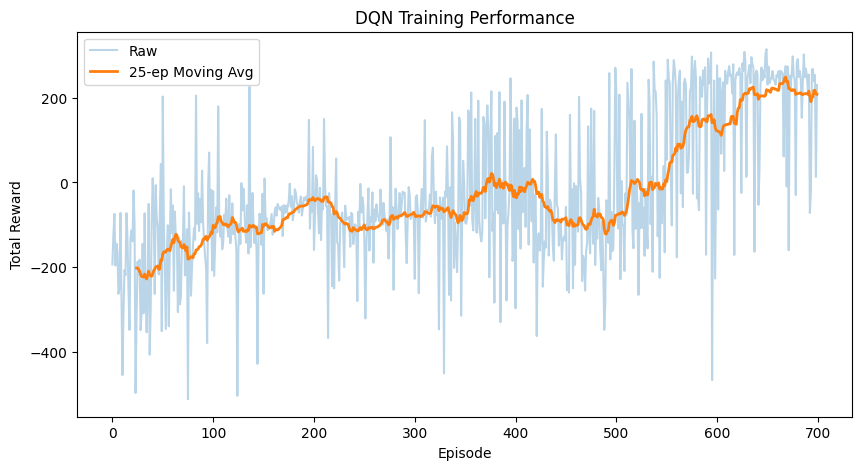

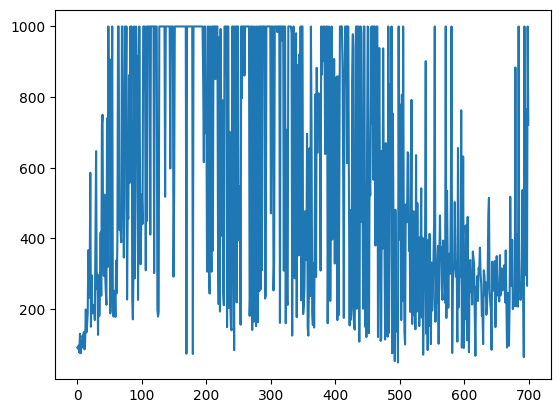

In [ ]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.95,15, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

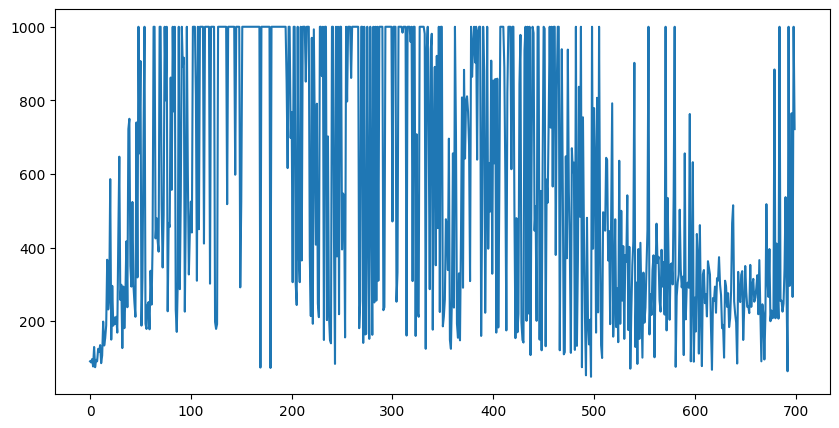

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(durations)

### Slightly faster decay:

Episode 0, Total Reward: -124.44, AVG Reward(last 25 eps): -124.44 Epsilon: 1.00
Episode 25, Total Reward: -130.91, AVG Reward(last 25 eps): -171.16 Epsilon: 0.82
Episode 50, Total Reward: -34.22, AVG Reward(last 25 eps): -122.53 Epsilon: 0.67
Episode 75, Total Reward: -139.92, AVG Reward(last 25 eps): -143.66 Epsilon: 0.55
Episode 100, Total Reward: -164.80, AVG Reward(last 25 eps): -113.67 Epsilon: 0.45
Episode 125, Total Reward: -83.12, AVG Reward(last 25 eps): -104.72 Epsilon: 0.37
Episode 150, Total Reward: -176.45, AVG Reward(last 25 eps): -128.77 Epsilon: 0.30
Episode 175, Total Reward: -85.36, AVG Reward(last 25 eps): -128.70 Epsilon: 0.25
Episode 200, Total Reward: -16.72, AVG Reward(last 25 eps): -104.50 Epsilon: 0.20
Episode 225, Total Reward: -59.19, AVG Reward(last 25 eps): -72.09 Epsilon: 0.16
Episode 250, Total Reward: -305.18, AVG Reward(last 25 eps): -113.43 Epsilon: 0.13
Episode 275, Total Reward: -59.23, AVG Reward(last 25 eps): -74.56 Epsilon: 0.11
Episode 300, Tota

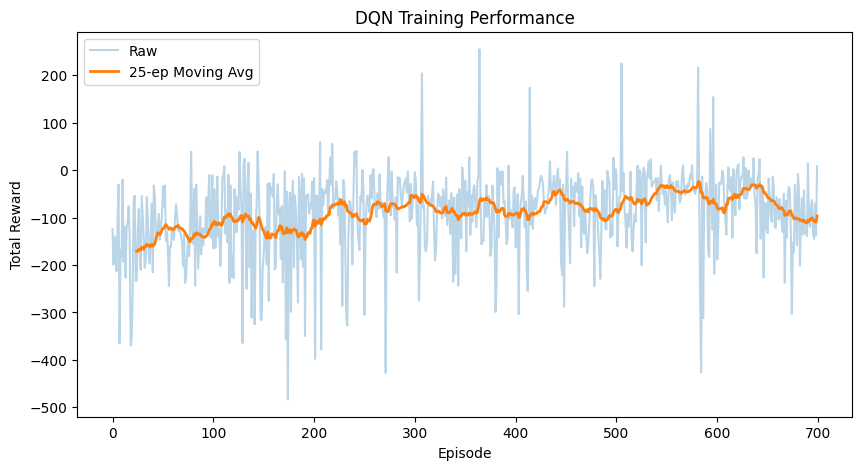

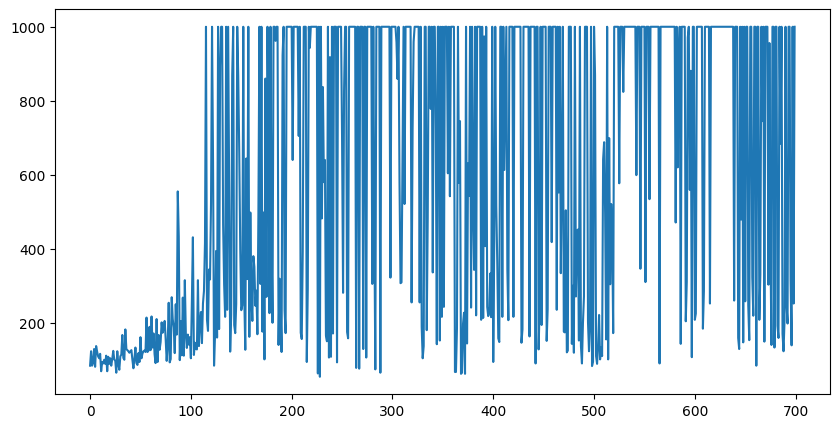

In [ ]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.992,15, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### faster target updates:

Episode 0, Total Reward: -119.60, AVG Reward(last 25 eps): -119.60 Epsilon: 1.00
Episode 25, Total Reward: -113.43, AVG Reward(last 25 eps): -161.38 Epsilon: 0.82
Episode 50, Total Reward: -177.70, AVG Reward(last 25 eps): -110.80 Epsilon: 0.67
Episode 75, Total Reward: -214.43, AVG Reward(last 25 eps): -119.26 Epsilon: 0.55
Episode 100, Total Reward: -77.15, AVG Reward(last 25 eps): -109.90 Epsilon: 0.45
Episode 125, Total Reward: -66.31, AVG Reward(last 25 eps): -104.19 Epsilon: 0.37
Episode 150, Total Reward: -50.15, AVG Reward(last 25 eps): -136.38 Epsilon: 0.30
Episode 175, Total Reward: -17.65, AVG Reward(last 25 eps): -80.76 Epsilon: 0.25
Episode 200, Total Reward: -37.25, AVG Reward(last 25 eps): -12.71 Epsilon: 0.20
Episode 225, Total Reward: -71.15, AVG Reward(last 25 eps): -38.15 Epsilon: 0.16
Episode 250, Total Reward: -43.24, AVG Reward(last 25 eps): 136.03 Epsilon: 0.13
Episode 275, Total Reward: 203.37, AVG Reward(last 25 eps): 127.14 Epsilon: 0.11
Episode 300, Total Rew

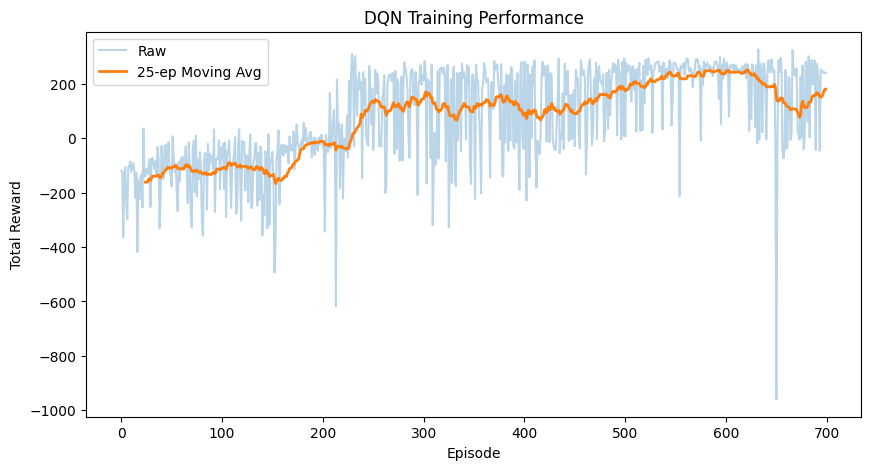

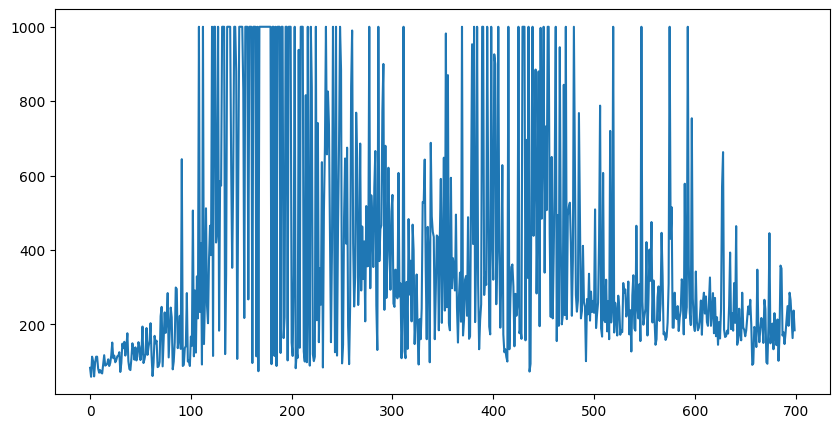

In [ ]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.992,5, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### slower target updates:

Episode 0, Total Reward: -326.13, AVG Reward(last 25 eps): -326.13 Epsilon: 1.00
Episode 25, Total Reward: -136.32, AVG Reward(last 25 eps): -161.13 Epsilon: 0.88
Episode 50, Total Reward: -178.02, AVG Reward(last 25 eps): -130.96 Epsilon: 0.78
Episode 75, Total Reward: -136.44, AVG Reward(last 25 eps): -122.85 Epsilon: 0.69
Episode 100, Total Reward: -52.77, AVG Reward(last 25 eps): -102.74 Epsilon: 0.61
Episode 125, Total Reward: -25.70, AVG Reward(last 25 eps): -95.68 Epsilon: 0.53
Episode 150, Total Reward: 26.57, AVG Reward(last 25 eps): -77.60 Epsilon: 0.47
Episode 175, Total Reward: -272.09, AVG Reward(last 25 eps): -130.02 Epsilon: 0.42
Episode 200, Total Reward: -180.10, AVG Reward(last 25 eps): -205.27 Epsilon: 0.37
Episode 225, Total Reward: -116.31, AVG Reward(last 25 eps): -136.33 Epsilon: 0.32
Episode 250, Total Reward: -29.76, AVG Reward(last 25 eps): -128.65 Epsilon: 0.29
Episode 275, Total Reward: -7.93, AVG Reward(last 25 eps): -63.30 Epsilon: 0.25
Episode 300, Total 

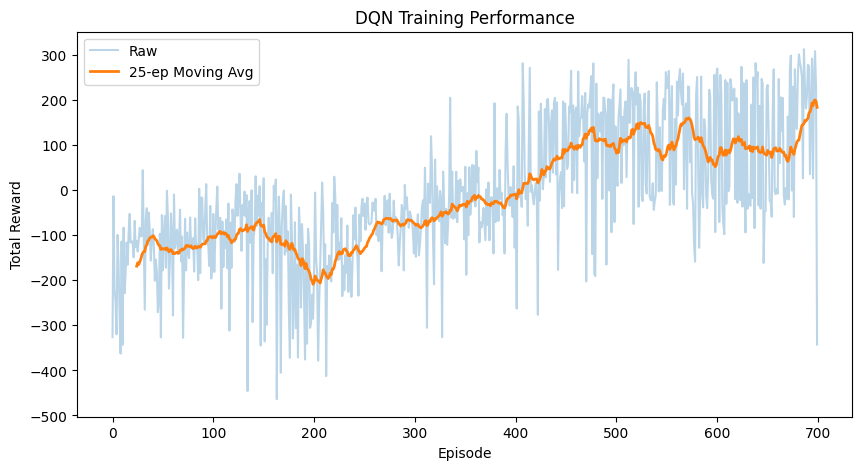

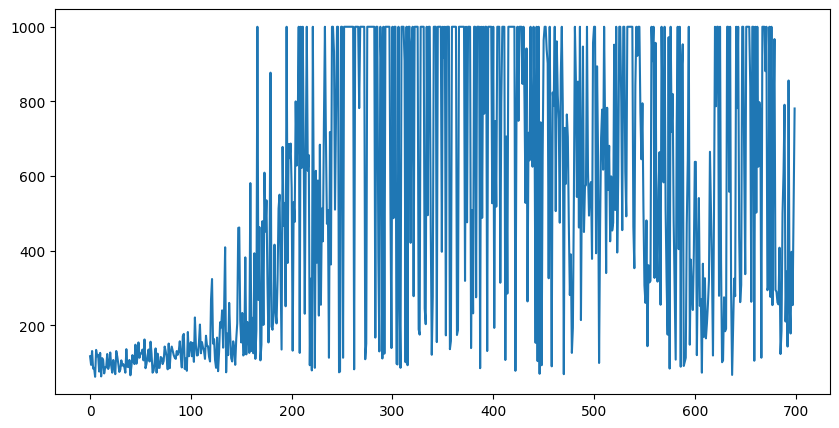

In [ ]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.995,7, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### testing bigger batch size:

Episode 0, Total Reward: -188.39, AVG Reward(last 25 eps): -188.39 Epsilon: 1.00
Episode 25, Total Reward: -45.91, AVG Reward(last 25 eps): -156.35 Epsilon: 0.88
Episode 50, Total Reward: -292.51, AVG Reward(last 25 eps): -169.59 Epsilon: 0.78
Episode 75, Total Reward: -98.14, AVG Reward(last 25 eps): -131.72 Epsilon: 0.69
Episode 100, Total Reward: -140.45, AVG Reward(last 25 eps): -126.05 Epsilon: 0.61
Episode 125, Total Reward: -77.93, AVG Reward(last 25 eps): -96.27 Epsilon: 0.53
Episode 150, Total Reward: -39.59, AVG Reward(last 25 eps): -127.16 Epsilon: 0.47
Episode 175, Total Reward: -122.15, AVG Reward(last 25 eps): -94.81 Epsilon: 0.42
Episode 200, Total Reward: -67.98, AVG Reward(last 25 eps): -142.71 Epsilon: 0.37
Episode 225, Total Reward: -74.86, AVG Reward(last 25 eps): -155.29 Epsilon: 0.32
Episode 250, Total Reward: -33.11, AVG Reward(last 25 eps): -174.37 Epsilon: 0.29
Episode 275, Total Reward: -41.09, AVG Reward(last 25 eps): -86.07 Epsilon: 0.25
Episode 300, Total R

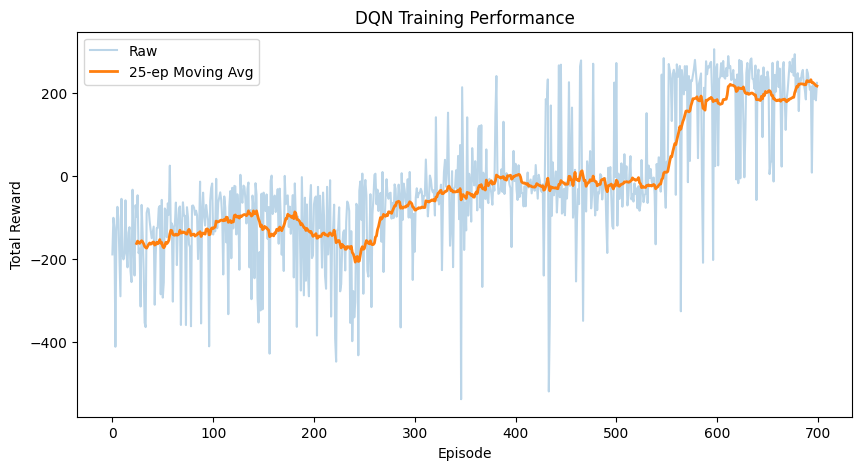

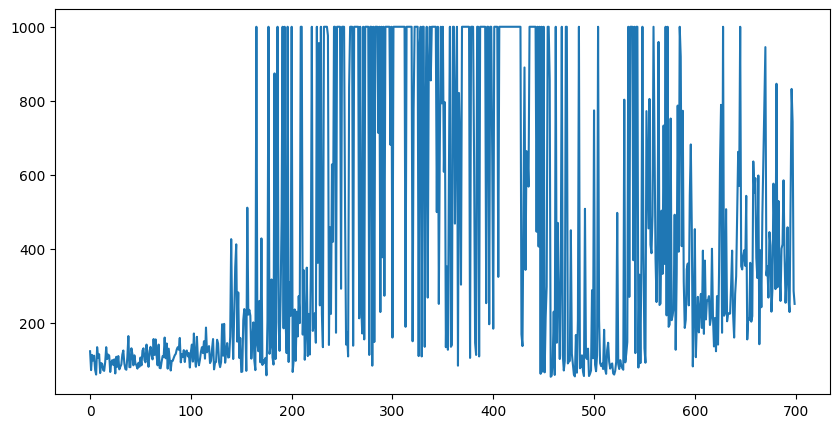

In [ ]:
agent, rewards, durations = train(700,128,0.99,1.0,0.01,0.995,5, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### smaller batch size:

In [ ]:
agent, rewards, durations = train(700,32,0.99,1.0,0.01,0.995,5, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

Episode 0, Total Reward: -126.07, AVG Reward(last 25 eps): -126.07 Epsilon: 1.00
Episode 25, Total Reward: -108.75, AVG Reward(last 25 eps): -175.95 Epsilon: 0.88
Episode 50, Total Reward: -140.01, AVG Reward(last 25 eps): -147.27 Epsilon: 0.78
Episode 75, Total Reward: -26.54, AVG Reward(last 25 eps): -102.92 Epsilon: 0.69
